# Initiation

In [1]:
# To manipulate arrays
import numpy as np 

# To handle track DataFrames
import pandas as pd

# For working with x-arrays
import xarray as xr

# To import images
from skimage import io 
from skimage.io import imread

# For TrackPy
import trackpy as tp

# To make plots
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()  

# To work inline; change to %matplotlib notebook for interactive plotting
%matplotlib inline 

# Napari 
#%gui qt5 
from skimage import data
#import napari

# Image processing and filters
from skimage.filters import difference_of_gaussians

# For directories 
import os
from pathlib import Path, PureWindowsPath # for working with windows paths

# For reloading a library when testing
import importlib

# For deleting/reloading modules in another file for code testing
import sys

# Import trackArrayTools
cwd = os.getcwd()
os.chdir("../croparray")
import crop_array_tools as ca
os.chdir(cwd)

plt.style.use('dark_background')


In [9]:
# parameters
particle_diameter=(3, 7, 7)   # z,y,x size of the spot
separation_spots=(1, 7, 7)    # distance in z,y,x to differentiate an spot

tracking_channel = 0
min_trajectory_length = 20

# selecting time and z for visualization
selected_time = 4 
selected_z = 3 

# Video directory
video_3D_directory = r'../database'
video_3D_filename = r'Hela_confocal.tif'  

In [4]:
# Read in video; note I added an fov dimension using np.array since this is only 1 fov
video = np.array([imread(os.path.join(video_3D_directory,video_3D_filename))])
video.shape # dimensions MUST be (fov, f = frame, z, y, x, ch)
video.shape

(1, 33, 7, 472, 312, 3)

(472, 312)


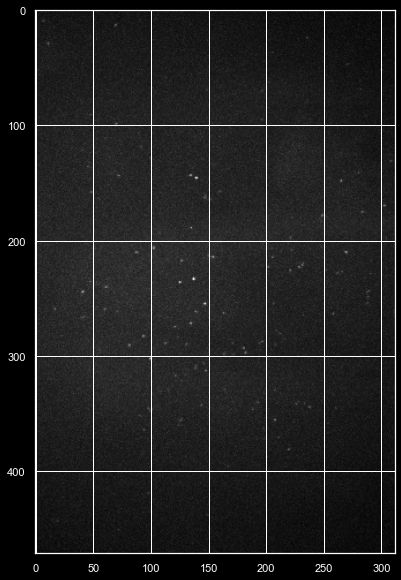

In [5]:
# Just examining one of the images
f = plt.figure(figsize=(10,10))
myimg=np.max(video[0,selected_time,:,:,:,tracking_channel] ,axis=0)
print(myimg.shape)
plt.imshow(myimg,cmap='gray')

In [11]:
# bach processing
#(1, 21, 928, 624, 4)
f = tp.batch(video[0,:, :, :, :,tracking_channel], diameter=particle_diameter, separation=separation_spots)
# Converting pixels to nm
f['xum'] = f['x'] * 0.13
f['yum'] = f['y'] * 0.13
f['zum'] = f['z'] * 0.5
# linking and filtering trajectories
linked = tp.link_df(f, 0.5, pos_columns=['xum', 'yum', 'zum'])
filtered_df = tp.filter_stubs(linked, min_trajectory_length)
filtered_df.rename(columns={'x': 'xc','y': 'yc', 'z': 'zc', 'frame': 'f','particle':'id','mass':'MEAN_INTENSITY'}, inplace=True, errors='raise')
spots = filtered_df.astype({'zc': int,'yc': int,'xc': int,'f': int,'id': int,'MEAN_INTENSITY': int})
spots['fov']= 0  
spots=spots[['fov','f','id','zc','yc','xc','MEAN_INTENSITY']]
spots

Frame 32: 2289 trajectories present.


,fov,f,id,zc,yc,xc,MEAN_INTENSITY
frame,,,,,,,
0,0,0,178,3,89,46,71
0,0,0,187,4,122,41,44
0,0,0,292,3,284,122,96
0,0,0,300,2,287,168,93
0,0,0,386,2,230,255,80
...,...,...,...,...,...,...,...
32,0,32,1241,1,154,46,56
32,0,32,1747,1,204,99,150
32,0,32,1541,1,206,86,78


In [12]:
my_ca = ca.create_crop_array(video,spots,xy_pad=5)
my_ca

Original video dimensions:  (1, 33, 7, 472, 312, 3)
Padded video dimensions:  (1, 33, 7, 484, 324, 3)
Max # of spots per frame:  40
Shape of numpy array to hold all crop intensity data:  (1, 40, 33, 7, 11, 11, 3)
Shape of xc and yc numpy arrays:  (1, 40, 33, 3)
Shape of extra my_layers numpy array:  (3, 1, 40, 33)


<xarray.Dataset>
Dimensions:         (fov: 1, n: 40, t: 33, z: 7, y: 11, x: 11, ch: 3)
Coordinates:
  * fov             (fov) int64 0
  * n               (n) int64 0 1 2 3 4 5 6 7 8 9 ... 31 32 33 34 35 36 37 38 39
  * t               (t) int64 0 1 2 3 4 5 6 7 8 9 ... 24 25 26 27 28 29 30 31 32
  * z               (z) int64 0 1 2 3 4 5 6
  * y               (y) int64 -5 -4 -3 -2 -1 0 1 2 3 4 5
  * x               (x) int64 -5 -4 -3 -2 -1 0 1 2 3 4 5
  * ch              (ch) int64 0 1 2
Data variables:
    int             (fov, n, t, z, y, x, ch) int64 24 25 42 27 42 ... 0 0 0 0 0
    xc              (fov, n, t, ch) int64 52 52 52 25 25 25 176 ... 0 0 0 0 0 0
    yc              (fov, n, t, ch) int64 95 95 95 448 448 448 ... 0 0 0 0 0 0
    dx              int64 1
    dy              int64 1
    dz              int64 1
    dt              int64 1
    id              (fov, n, t) float64 178.0 2.261e+03 300.0 ... 0.0 0.0 0.0
    zc              (fov, n, t) float64 3.0 2.0 3.0 2.0 4.0 ... 0.0 0.0 0.0 0.0
    MEAN_INTENSITY  (fov, n, t) float64 71.0 86.0 72.0 72.0 ... 0.0 0.0 0.0 0.0
Attributes:
    units:    ['space', 'time']
    name:     video_filename
    date:     video_date

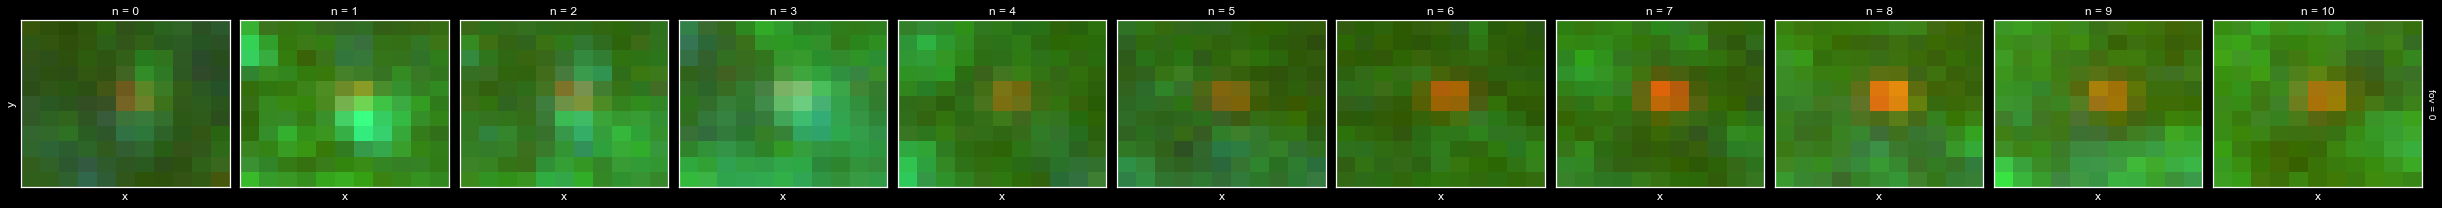

In [26]:
# Check the first 10 spots (max-z projected) of each fov to make sure things are centered. 
# Choosing ch = 1, 2 (translation), and 3 for rgb mapping
my_ca.int.sel(ch=[0,1,2],n=slice(0,10)).mean(dim=['t']).max('z').plot.imshow(col='n',row='fov',rgb='ch',cmap='gray',xticks=[],yticks=[])

In [16]:
# Create best-z projection using channel 2 (translation) as a reference. taking bestz +/- 1 here (roll_n = 3)
best_z = ca.best_z_proj(my_ca, ref_ch=2, disk_r=3, roll_n=3)
best_z = my_ca.int.max('z')

# measure intensity in disk with radius of 3 pixels:
disk_sig = best_z.where(lambda a: a.x**2 + a.y**2 <= (3*my_ca.dx)**2).mean(dim=['x','y'])

# measure intensity in donut with width 1 pixel and inner radius of 5 pixels:
donut_sig = best_z.where(lambda a: (a.x**2 + a.y**2 >= (5*my_ca.dx)**2) & (a.x**2 + a.y**2 < (6*my_ca.dx)**2)).mean(dim=['x','y'])

# disk-donut intensity quantification
signal = disk_sig - donut_sig 

# create a best-z projection that is background subtracted
best_z_bg = best_z -donut_sig

# add signal layer to original crop array for sorting and things
my_ca['signal'] = signal

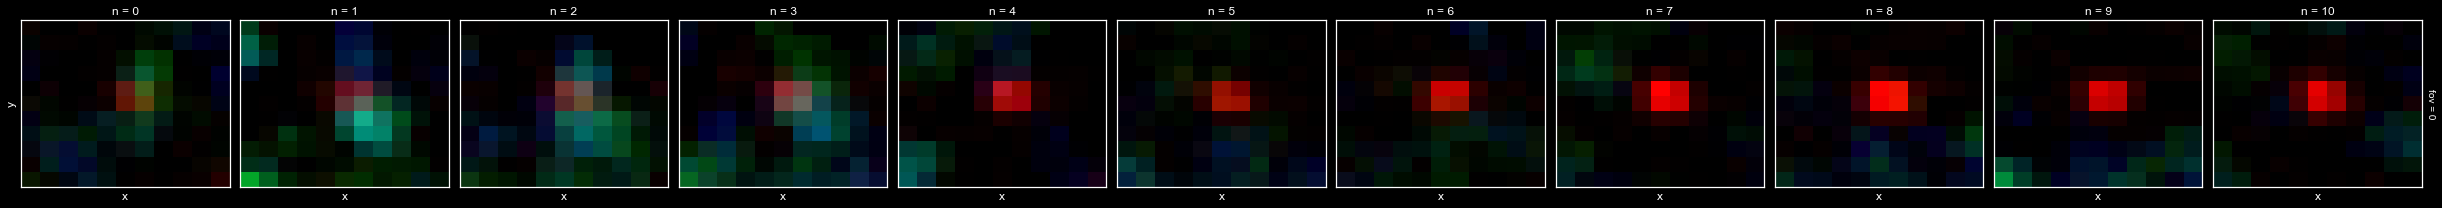

In [18]:
# Repeat measurement above, but looking at background-subtracted image instead of standard max-projection
# You can see a big improvement in signal, by taking the best plane... Can get slighly better with roll_n = 1 above, but more noisy?
best_z_bg.sel(ch=[0,1,2],n=slice(0,10)).mean(dim=['t']).plot.imshow(col='n',row='fov',rgb='ch',cmap='gray',xticks=[],yticks=[],vmin=0, vmax=30000,aspect=1)